In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r"C:\Users\neba\Desktop\brent_oil\data\raw\BrentOilPrices_Yearly.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Data overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

Data overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 29 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Year                                                       36 non-null     int64  
 1   Avg_Price                                                  36 non-null     float64
 2   Inflation (USA)                                            36 non-null     float64
 3   Inflation (China)                                          36 non-null     float64
 4   Inflation (India)                                          36 non-null     float64
 5   Inflation (Japan)                                          36 non-null     float64
 6   Inflation (Germany)                                        36 non-null     float64
 7   Inflation (France)                                         36 non-null     float64
 8

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load the data
file_path = r"C:\Users\neba\Desktop\brent_oil\data\raw\BrentOilPrices_Yearly.csv"
df = pd.read_csv(file_path)

# Convert string columns to numeric where appropriate
# Federal Funds and WTA Crude columns need to be cleaned of '%' and converted
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].str.replace('%', '').astype(float)
        except:
            pass  # Keep as string if conversion fails

# Set year as index but keep as a column too
df['Year_col'] = df['Year']
df.set_index('Year', inplace=True)

# Create a processed dataset folder
import os
processed_dir = r"C:\Users\neba\Desktop\brent_oil\data\processed"
os.makedirs(processed_dir, exist_ok=True)

# Save the cleaned data
df.to_csv(os.path.join(processed_dir, "brent_oil_cleaned.csv"))

# Basic visualizations
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Avg_Price'], marker='o', linestyle='-', linewidth=2)
plt.title('Brent Oil Average Price (1987-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(processed_dir, 'brent_oil_price_trend.png'))
plt.close()

# Check for stationarity
result = adfuller(df['Avg_Price'].dropna())
print(f"Augmented Dickey-Fuller Test for Brent Oil Prices:")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Create first difference if non-stationary
if result[1] > 0.05:
    df['Price_Diff'] = df['Avg_Price'].diff()
    
    # Plot the differenced series
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[1:], df['Price_Diff'][1:], marker='o', linestyle='-', color='orange')
    plt.title('First Difference of Brent Oil Prices', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Price Change (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(processed_dir, 'brent_oil_price_diff.png'))
    plt.close()
    
    # Check stationarity of differenced series
    result_diff = adfuller(df['Price_Diff'].dropna())
    print(f"\nADF Test after differencing:")
    print(f'ADF Statistic: {result_diff[0]}')
    print(f'p-value: {result_diff[1]}')

Augmented Dickey-Fuller Test for Brent Oil Prices:
ADF Statistic: -1.138254089852447
p-value: 0.6995781220115603
Critical Values:
	1%: -3.6327426647230316
	5%: -2.9485102040816327
	10%: -2.6130173469387756

ADF Test after differencing:
ADF Statistic: -3.7665784747013116
p-value: 0.003268379907973946


In [4]:
# Correlation analysis with economic indicators
# Select relevant columns for correlation analysis
economic_factors = [
    'Avg_Price', 'Inflation (USA)', 'Inflation (China)', 'Inflation (India)',
    'Inflation (Japan)', 'Inflation (Germany)', 'Inflation (France)',
    'Unemployment (USA)', 'Unemployment (China)', 'Unemployment (India)',
    'GDP USA', 'GDP CHINA', 'GDP JAPAN', 'GDP INDIA', 'GDP FRANCE'
]

# Create correlation matrix
corr_df = df[economic_factors].dropna()
correlation = corr_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Between Brent Oil Prices and Economic Factors', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(processed_dir, 'correlation_heatmap.png'))
plt.close()

# Create scatter plots for top correlating factors
# Find top 5 factors correlated with oil prices
top_correlations = correlation['Avg_Price'].abs().sort_values(ascending=False)[1:6]
top_factors = top_correlations.index.tolist()

# Create scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, factor in enumerate(top_factors):
    sns.regplot(x=factor, y='Avg_Price', data=df, ax=axes[i])
    axes[i].set_title(f'Oil Price vs {factor}', fontsize=14)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(processed_dir, 'top_factors_scatter.png'))
plt.close()

In [5]:
import pandas as pd

# Load dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\raw\BrentOilPrices_Yearly.csv"
df = pd.read_csv(file_path)

# Convert percentage columns to float
percentage_columns = [
    "Federal Funds Average Yield", "Federal Funds Year Open", "Federal Funds Year High",
    "Federal Funds Year Low", "Federal Funds Year Close", "Federal Funds Annual % change",
    "WTA Crude Oil Annual % Change"
]

for col in percentage_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('%', '').astype(float)

# Convert unemployment columns to float
unemployment_columns = [
    "Europe & Central Asia (IDA & IBRD countries) Unemployment",
    "Unemployment (USA)", "Unemployment (China)", "Unemployment (India)"
]

for col in unemployment_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Save cleaned dataset
cleaned_file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned data saved to: {cleaned_file_path}")

Cleaned data saved to: C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv


In [6]:
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Data overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

Data overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 29 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Year                                                       36 non-null     int64  
 1   Avg_Price                                                  36 non-null     float64
 2   Inflation (USA)                                            36 non-null     float64
 3   Inflation (China)                                          36 non-null     float64
 4   Inflation (India)                                          36 non-null     float64
 5   Inflation (Japan)                                          36 non-null     float64
 6   Inflation (Germany)                                        36 non-null     float64
 7   Inflation (France)                                         36 non-null     float64
 8

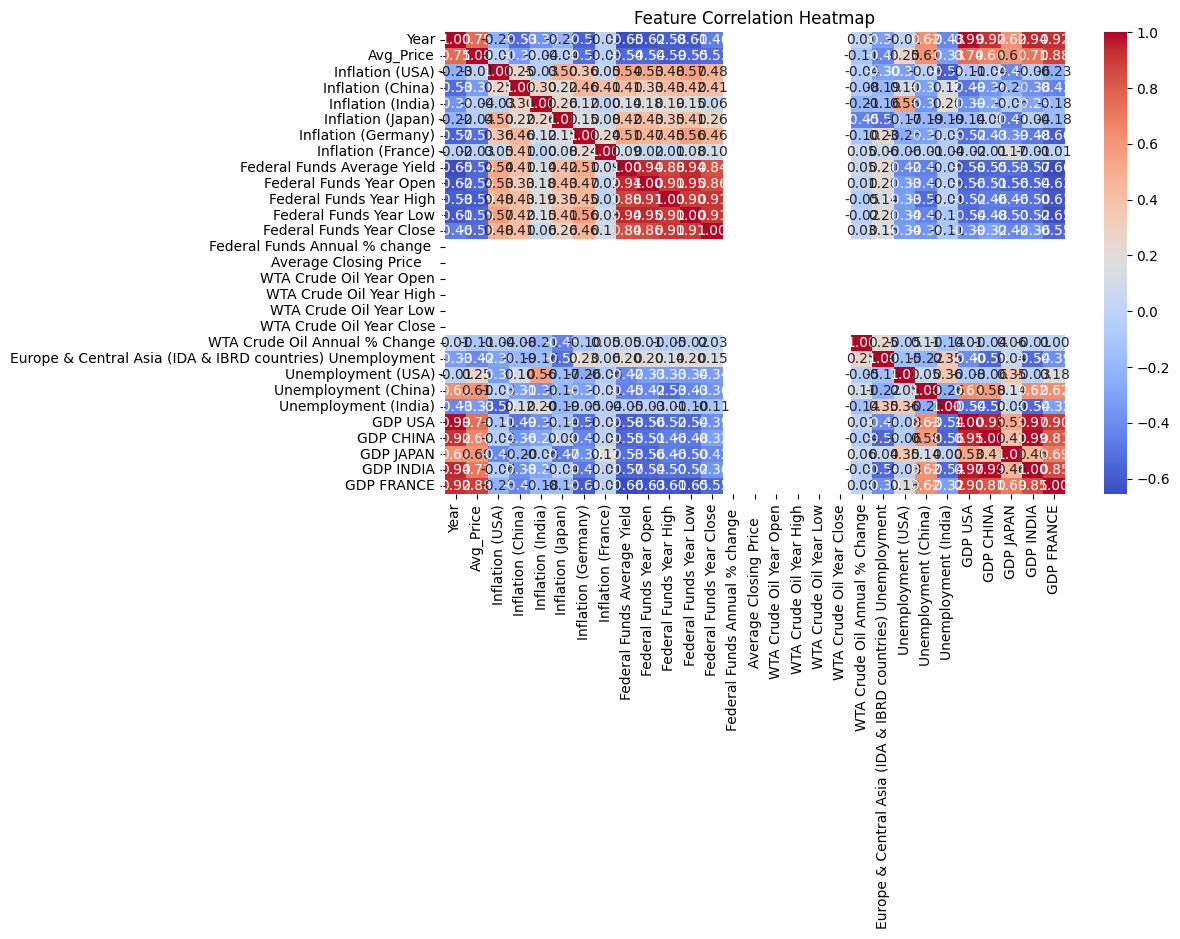

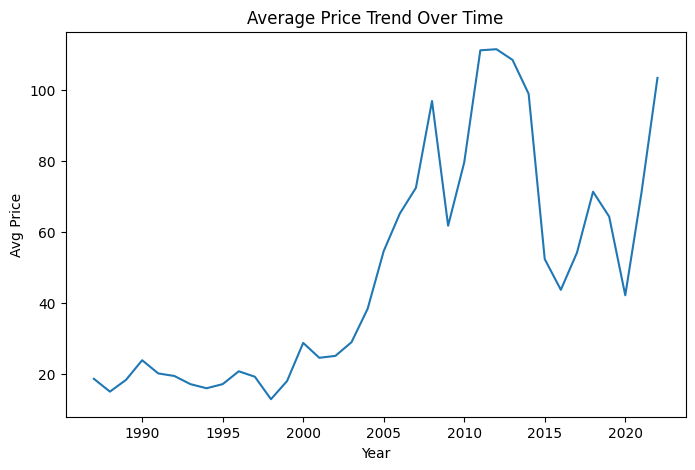


Summary Statistics:
               Year   Avg_Price  Inflation (USA)  Inflation (China)  \
count    36.000000   36.000000        36.000000          36.000000   
mean   2004.500000   48.424812         2.775000           4.769444   
std      10.535654   32.508184         1.519657           6.143560   
min    1987.000000   12.758103        -0.400000          -1.400000   
25%    1995.750000   19.266923         1.750000           1.550000   
50%    2004.500000   40.180355         2.750000           2.600000   
75%    2013.250000   70.975252         3.400000           5.675000   
max    2022.000000  111.570683         8.000000          24.300000   

       Inflation (India)  Inflation (Japan)  Inflation (Germany)  \
count          36.000000          36.000000            36.000000   
mean            7.363889           0.547222            19.858333   
std             2.941637           1.159676            11.986001   
min             3.600000          -1.400000             6.700000   
25%    

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load dataset (Replace 'your_file.csv' with actual file path)
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Step 1: Convert incorrect data types
for col in df.columns:
    if df[col].dtype == 'object':  # Assuming object columns should be numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 2: Check for anomalies
summary_stats = df.describe()

# Identify negative values in inflation columns
inflation_cols = [col for col in df.columns if 'Inflation' in col]
negative_inflation = df[inflation_cols][df[inflation_cols] < 0].dropna(how='all')

# Step 3: Check for missing values
missing_values = df.isnull().sum()

# Step 4: Outlier detection using z-score
z_scores = df.apply(zscore)
outliers = (np.abs(z_scores) > 3).sum()

# Step 5: Normalize data (if necessary)
df_normalized = (df - df.min()) / (df.max() - df.min())

# Step 6: Correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 7: Visualizations
# Example: Trend of Avg_Price over Years
if 'Year' in df.columns and 'Avg_Price' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Year', y='Avg_Price', data=df)
    plt.title('Average Price Trend Over Time')
    plt.xlabel('Year')
    plt.ylabel('Avg Price')
    plt.show()

# Print reports
print("\nSummary Statistics:\n", summary_stats)
print("\nNegative Inflation Values:\n", negative_inflation)
print("\nMissing Values:\n", missing_values)
print("\nOutlier Count per Column:\n", outliers)

In [19]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Print the columns of the DataFrame
print(df.columns)

Index(['Year', 'Avg_Price', 'Inflation (USA)', 'Inflation (China)',
       'Inflation (India)', 'Inflation (Japan)', 'Inflation (Germany)',
       'Inflation (France)', 'Federal Funds Average Yield',
       'Federal Funds Year Open', 'Federal Funds Year High',
       'Federal Funds Year Low', 'Federal Funds Year Close',
       'Federal Funds Annual % change ', 'Average Closing Price   ',
       'WTA Crude Oil Year Open', 'WTA Crude Oil Year High',
       'WTA Crude Oil Year Low', 'WTA Crude Oil Year Close',
       'WTA Crude Oil Annual % Change',
       'Europe & Central Asia (IDA & IBRD countries) Unemployment',
       'Unemployment (USA)', 'Unemployment (China)', 'Unemployment (India)',
       'GDP USA', 'GDP CHINA', 'GDP JAPAN', 'GDP INDIA', 'GDP FRANCE'],
      dtype='object')


In [20]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Convert relevant columns to numeric, forcing errors to NaN (if any)
columns_to_convert = [
    'Avg_Price', 'Inflation (USA)', 'Inflation (China)', 'Inflation (India)', 
    'Inflation (Japan)', 'Inflation (Germany)', 'Inflation (France)', 
    'Federal Funds Average Yield', 'Federal Funds Year Open', 
    'Federal Funds Year High', 'Federal Funds Year Low', 'Federal Funds Year Close', 
    'Federal Funds Annual % change', 'Average Closing Price', 
    'WTA Crude Oil Year Open', 'WTA Crude Oil Year High', 'WTA Crude Oil Year Low', 
    'WTA Crude Oil Year Close', 'WTA Crude Oil Annual % Change', 
    'Europe & Central Asia (IDA & IBRD countries) Unemployment', 
    'Unemployment (USA)', 'Unemployment (China)', 'Unemployment (India)', 
    'GDP USA', 'GDP CHINA', 'GDP JAPAN', 'GDP INDIA', 'GDP FRANCE'
]

# Convert columns to numeric
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate the correlation matrix for all columns
correlation_matrix = df.corr()

# Extract the correlation values for 'Avg_Price' and sort them
avg_price_corr = correlation_matrix['Avg_Price'].sort_values(ascending=False)

# Display the result
print(avg_price_corr)

Avg_Price                                                    1.000000
GDP FRANCE                                                   0.883835
Year                                                         0.748065
GDP USA                                                      0.736781
GDP INDIA                                                    0.710435
GDP CHINA                                                    0.663119
Unemployment (China)                                         0.611468
GDP JAPAN                                                    0.595700
Unemployment (USA)                                           0.253987
Inflation (USA)                                             -0.005927
Inflation (France)                                          -0.025700
Inflation (Japan)                                           -0.038208
Inflation (India)                                           -0.040826
WTA Crude Oil Annual % Change                               -0.105616
Unemployment (India)

In [24]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Select the specific columns you want to output
columns_to_output = [
    'Federal Funds Annual % change', 'Average Closing Price', 
    'WTA Crude Oil Year Open', 'WTA Crude Oil Year High', 
    'WTA Crude Oil Year Low', 'WTA Crude Oil Year Close'
]

# Output the selected columns
selected_data = df[columns_to_output]
print(selected_data)

   Federal Funds Annual % change Average Closing Price  \
0                           -0.5                  19.2   
1                         31.20%               $15.97    
2                        -11.84%               $19.64    
3                        -30.61%               $24.53    
4                        -26.04%               $21.54    
5                        -34.96%               $20.58    
6                          7.14%               $18.43    
7                         73.33%               $17.20    
8                         -4.25%               $18.43    
9                         32.35%               $22.12    
10                        -6.71%               $20.61    
11                       -30.31%               $14.42    
12                        -1.97%               $19.35    
13                        35.59%               $30.38    
14                       -71.90%               $25.98    
15                       -23.68%               $26.19    
16            

In [25]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Function to clean the strings and convert to numeric
def clean_and_convert(value):
    if isinstance(value, str):
        # Remove '%' and '$' symbols and handle potential commas
        value = value.replace('%', '').replace('$', '').replace(',', '')
    try:
        return pd.to_numeric(value)
    except ValueError:
        return value  # Return as is if it can't be converted

# Clean the selected columns
columns_to_clean = [
    'Federal Funds Annual % change', 'Average Closing Price', 
    'WTA Crude Oil Year Open', 'WTA Crude Oil Year High', 
    'WTA Crude Oil Year Low', 'WTA Crude Oil Year Close'
]

for col in columns_to_clean:
    df[col] = df[col].apply(clean_and_convert)

# Output the cleaned data
selected_data = df[columns_to_clean]
print(selected_data)

    Federal Funds Annual % change  Average Closing Price  \
0                           -0.50                  19.20   
1                           31.20                  15.97   
2                          -11.84                  19.64   
3                          -30.61                  24.53   
4                          -26.04                  21.54   
5                          -34.96                  20.58   
6                            7.14                  18.43   
7                           73.33                  17.20   
8                           -4.25                  18.43   
9                           32.35                  22.12   
10                          -6.71                  20.61   
11                         -30.31                  14.42   
12                          -1.97                  19.35   
13                          35.59                  30.38   
14                         -71.90                  25.98   
15                         -23.68       

In [26]:
# Calculate correlation with 'Avg_Price'
correlation = df[['Avg_Price'] + columns_to_clean].corr()

# Output the correlation results
print(correlation['Avg_Price'])

Avg_Price                        1.000000
Federal Funds Annual % change    0.044578
Average Closing Price            0.993423
WTA Crude Oil Year Open          0.963548
WTA Crude Oil Year High          0.969042
WTA Crude Oil Year Low           0.923571
WTA Crude Oil Year Close         0.883179
Name: Avg_Price, dtype: float64


In [28]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Function to clean the strings and convert to numeric
def clean_and_convert(value):
    if isinstance(value, str):
        # Remove '%' and '$' symbols and handle potential commas
        value = value.replace('%', '').replace('$', '').replace(',', '')
    try:
        return pd.to_numeric(value)
    except ValueError:
        return value  # Return as is if it can't be converted

# Clean the selected columns
columns_to_clean = [
    'Federal Funds Annual % change', 'Average Closing Price', 
    'WTA Crude Oil Year Open', 'WTA Crude Oil Year High', 
    'WTA Crude Oil Year Low', 'WTA Crude Oil Year Close'
]

for col in columns_to_clean:
    df[col] = df[col].apply(clean_and_convert)

# Save the cleaned data back to the original file
df.to_csv(file_path, index=False)

print(f"Cleaned data saved to {file_path}")

Cleaned data saved to C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv


Basic Dataset Information:
Shape: (36, 29)

First few rows:
   Year  Avg_Price  Inflation (USA)  Inflation (China)  Inflation (India)  \
0  1987  18.525813              3.7                7.2                8.8   
1  1988  14.905412              4.1               18.9                9.4   
2  1989  18.228228              4.8               18.2                7.1   
3  1990  23.761445              5.4                3.0                9.0   
4  1991  20.041128              4.2                3.6               13.9   

   Inflation (Japan)  Inflation (Germany)  Inflation (France)  \
0                0.1                 39.8                -1.0   
1                0.7                 31.4                -9.8   
2                2.3                 25.2                 6.9   
3                3.1                 37.2                15.4   
4                3.3                 18.1                -9.8   

   Federal Funds Average Yield  Federal Funds Year Open  ...  \
0                     

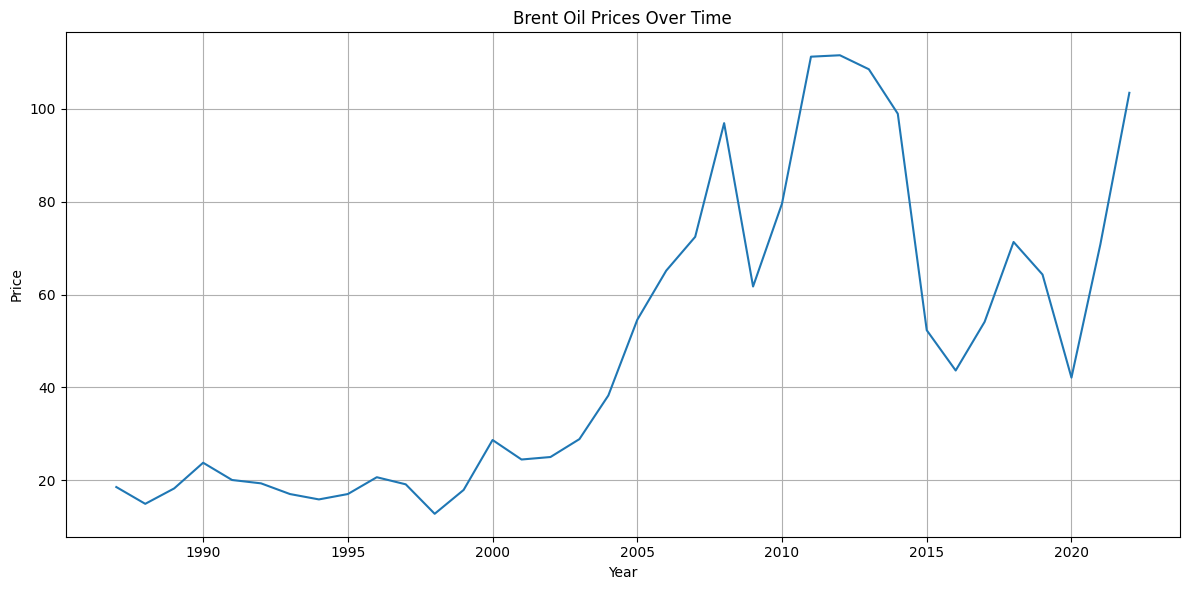


Stationarity Test for Brent Oil Prices:
ADF Statistic: -1.1383
p-value: 0.6996
Critical Values:
	1%: -3.6327
	5%: -2.9485
	10%: -2.6130
The series is non-stationary (fail to reject H0)

Stationarity Test for First Difference:
ADF Statistic: -3.7666
p-value: 0.0033
The first difference is stationary (reject H0)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# 1. DATA EXPLORATION
print("Basic Dataset Information:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for a date/year column
year_cols = [col for col in df.columns if 'year' in col.lower()]
if not year_cols:
    # If no explicit year column, check if there's an index that might be years
    if df.index.dtype == 'int64' and 1900 <= df.index.min() <= 2100 and 1900 <= df.index.max() <= 2100:
        print("\nIndex appears to be years")
        df['Year'] = df.index
        time_col = 'Year'
    else:
        # Create a year column if needed
        print("\nNo explicit year column found. Creating a sequential year column.")
        df['Year'] = pd.date_range(start='1990-01-01', periods=len(df), freq='Y').year
        time_col = 'Year'
else:
    time_col = year_cols[0]
    print(f"\nUsing {time_col} as the time column")

# Identify target column (Brent oil price)
if 'Avg_Price' in df.columns:
    target_col = 'Avg_Price'
else:
    price_cols = [col for col in df.columns if 'price' in col.lower() or 'brent' in col.lower()]
    if price_cols:
        target_col = price_cols[0]
    else:
        print("Could not identify Brent oil price column. Please specify.")
        target_col = df.columns[0]  # Default to first column

print(f"\nTarget column (Brent oil price): {target_col}")

# Time series analysis
if time_col in df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df[time_col], df[target_col])
    plt.title(f'Brent Oil Prices Over Time')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. STATIONARITY TEST
print("\nStationarity Test for Brent Oil Prices:")
result = adfuller(df[target_col].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.4f}')

# Interpret stationarity
is_stationary = result[1] < 0.05
if is_stationary:
    print("The series is stationary (reject H0)")
else:
    print("The series is non-stationary (fail to reject H0)")
    
    # Test first difference if non-stationary
    df[f'{target_col}_diff'] = df[target_col].diff().fillna(0)
    result_diff = adfuller(df[f'{target_col}_diff'].iloc[1:])
    print("\nStationarity Test for First Difference:")
    print(f'ADF Statistic: {result_diff[0]:.4f}')
    print(f'p-value: {result_diff[1]:.4f}')
    is_diff_stationary = result_diff[1] < 0.05
    if is_diff_stationary:
        print("The first difference is stationary (reject H0)")
    else:
        print("The first difference is non-stationary (fail to reject H0)")